# Non cartesian sampling: SPARKLING imaging

We explore the performance of SPARKLING (_Spreading projection Algorithm for Rapid K-space sampLING_) as non-Cartesian imaging technique. We do not actually provide the code of this algorithm but instead upload result files containing trajectories generated from the previous *radial in-out* initialization. For details, see the recently published paper: Lazarus et al, "SPARKLING: variable‐density k‐space filling curves for accelerated $T_2^*$ ‐weighted MRI", Magn Reson Med 2019; 81:3643:3661. 

- Authors: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 04/02/2019
- Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**
- **Revision**: 01/06/2021 for ATSI MSc hands-on session at Paris-Saclay University.

<IPython.core.display.Javascript object>


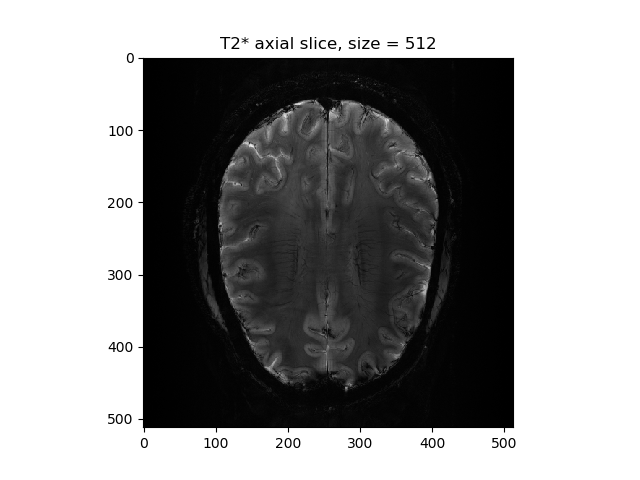

In [6]:
#DISPLAY T2* MR IMAGE 
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib
import matplotlib.pyplot as plt
import sys

from mri.operators import NonCartesianFFT
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from pysap.data import get_sample_data


from skimage import data, img_as_float, io, filters
from modopt.math.metrics import ssim

mri_img = get_sample_data('2d-mri')
img_size = mri_img.shape[0]

plt.figure()
plt.title("T2* axial slice, size = {}".format(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

1280.0


<IPython.core.display.Javascript object>


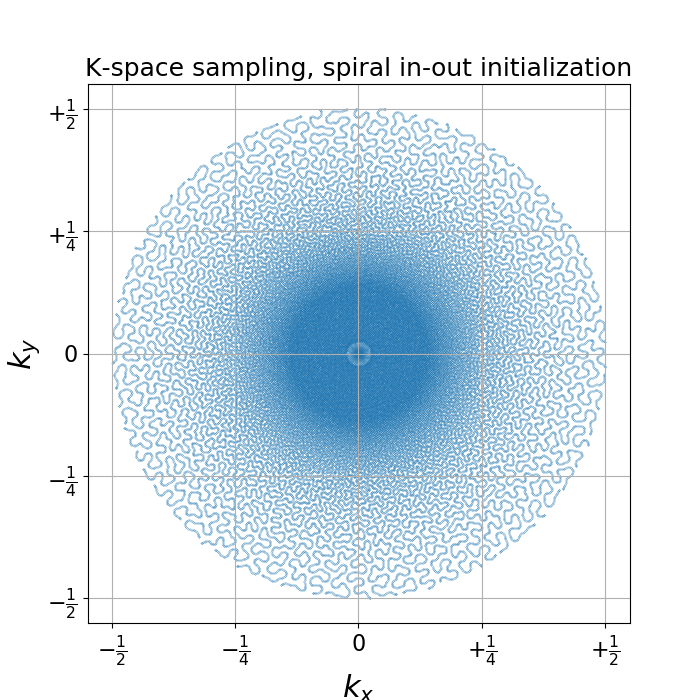

In [7]:
from scipy.io import loadmat

cwd = os.getcwd()
dirimg_2d = op.join(cwd,"..","data")

k_spark = loadmat(op.join(cwd, "..", "data","samples_SPARKLING_N512_nc34x3073_OS1.mat"))

k_spark_vec = k_spark['samples']

Kmax = np.amax(k_spark_vec)
#print(Kmax)

k_spark_vec = k_spark_vec*1/(2*np.pi*Kmax)

#save in npz format in the outdir directory
outdir = op.join(cwd,"..","output")
filename_traj = "sparkling_radial_N"  + str(img_size) + ".npz"
outfile = op.join(outdir, filename_traj)
np.savez(outfile, k_spark_vec)

k_spark = plt.figure(figsize=(7,7))
plt.scatter(k_spark_vec[:,0],k_spark_vec[:,1], marker = '.', s=0.1)
plt.grid()
#Figure layout

unit = 1/4
tick = np.arange(-0.5, 0.5 + unit, unit)

label = [r"$-\frac{1}{2}$", r"$-\frac{1}{4}$", r"$0$", r"$+\frac{1}{4}$",  r"$+\frac{1}{2}$"]

plt.xticks(tick/np.pi,labels = label, fontsize = 16) ; plt.yticks(tick/np.pi,labels = label, fontsize = 16)

plt.xlabel(r"$k_x$", fontsize = 22) ; plt.ylabel(r"$k_y$", fontsize = 22)

plt.title("K-space sampling, spiral in-out initialization",fontsize = 18)

plt.show()


In [9]:
data=convert_locations_to_mask(k_spark_vec, mri_img.shape)
fourier_op = NonCartesianFFT(samples=k_spark_vec, shape=mri_img.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(mri_img.data)

NameError: name 'pynfft' is not defined

In [ ]:
grid_space = np.linspace(-0.5, 0.5, num=mri_img.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(k_spark_vec, kspace_obs,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, mri_img)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

100% (100 of 100) |######################| Elapsed Time: 0:00:34 Time:  0:00:34


<IPython.core.display.Javascript object>


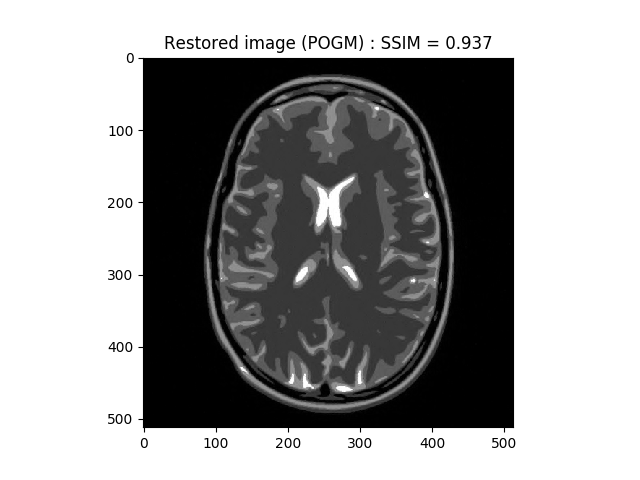

In [11]:
# fista rec using PySAP (branch pogm_addition: https://github.com/zaccharieramzi/pysap/tree/pogm_addition)

from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx
from mri.numerics.fourier import NFFT
from pysap import Image
from mri.numerics.gradient import GradAnalysis2
from mri.numerics.linear import WaveletN
from mri.numerics.reconstruct import sparse_rec_pogm
from mri.numerics.utils import convert_mask_to_locations
from modopt.math.metrics import ssim

## ops init
kspace_loc = convert_mask_to_locations(k_spark_vec)
linear_op = WaveletN(
    nb_scale=4,
    wavelet_name="db4",
    padding_mode="periodization",
)

fourier_op = NFFT(
    samples= k_spark_vec * np.pi,
    shape= mri_img.shape,
)

##compute the kspace data
kspace_data_nfft = fourier_op.op(mri_img)

## now back to ops
gradient_op = GradAnalysis2(
    data=kspace_data_nfft,
    fourier_op=fourier_op,
)

# define the proximity operator
prox_op = LinearCompositionProx(
    linear_op=linear_op,
    prox_op=SparseThreshold(Identity(), 0.05, thresh_type="soft"),
)

if 1:
    ## run pogm' (ie POGM with restart)
    x_final, costs, metrics = sparse_rec_pogm(prox_op=prox_op, linear_op=Identity(), gradient_op=gradient_op, 
                                   max_nb_of_iter=100, metric_call_period=20)

pogm_rec = np.abs(x_final)
img_rec = Image(data=pogm_rec)
#img_rec.show()
#img_rec = np.abs(x_final)
#print(metrics)
#SSIM

ssim_pogm = ssim(mri_img, pogm_rec)
ssim_pogm = float(round(abs(ssim_pogm),3))

plt.figure()
plt.title('Restored image (POGM) : SSIM = ' + str(ssim_pogm))
plt.imshow(pogm_rec, cmap='gray')
plt.show()